## Bazean Case Study: Analyzing Production Results for Oil Wells in the Bakken, North Dakota

### Thatcher Thornberry, University of Texas, Petroleum Engineering, Class of 2021

#### Contact: Thatch@utexas.edu

### Executive Summary: 
From historical production data, I needed to predict which companies are going to drill the best wells. This will aid in valuing these companies and finding the best point of investment. This production data contains some bad datapoints that need to be addressed. My method of addressing these was to remove production rates of less than 10bbls, and to ignore completion and spud dates from the wells file. I also adjusted the data in order to perform decline curve analysis
In regards to GOR, it was observed that Abraxas maintained the highest Gas to Oil Ration while Petro-Hunt held the lowest standing. In general, from 2010 to 2018, the GOR for all companies rose. 
From wells that began production in 2015, Enerplus Resources stood at the forefront of productivity and EUR with an Average Productivity Rating of 50.07 and Total EUR of 3.99e6 bbls. Crescent Point Energy held the lowest Average Productivity Rating of 13.00 and an EUR of 3.86e5 bbls.

Visualisation of these results can be found within the document.

#### Objective

Determine and summarize historical GOR over itme by the year put on production for each operator

Determine and summarize oil EUR per well that started producing in 2015.

Based on their history, which company or companies are likely to drill the most productive wells going forward?


###### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

###### Load the data into DataFrames
Pandas' DataFrame objects allow the data to be easily tracked and manipulated

In [2]:
dfprod = pd.read_csv('ND_PRODUCTION_DATA.csv', parse_dates = ['date'])
to_drop = ['producing_days','state']
dfprod.drop(to_drop,inplace=True,axis=1)
dfprod['year'] = dfprod['date'].apply(lambda x:x.year)
dfprod.head()

,api,date,index,volume_oil_formation_bbls,volume_gas_formation_mcf,volume_water_formation_bbls,year
0,33053026790000,2018-08-01,148,830,1629,234,2018
1,33053026790000,2018-07-01,147,917,1658,229,2018
2,33053026790000,2018-06-01,146,927,1478,232,2018
3,33053026790000,2018-05-01,145,980,1142,519,2018
4,33053026790000,2018-04-01,144,603,608,128,2018


The 'api' column houses a unique number for each well in the Baaken field. This DataFrame also has monthly measures of oil, gas, and water produced. I've dropped information that I don't need; like days producing and state that the well was in. I've also created a 'year' column by extracting the year from the 'date' column.

In [3]:
df1 = pd.read_csv('ND_WELL_DATA.csv', parse_dates = ['completion_date','spud_date'])
dfwell = df1[['api','completion_date','spud_date','cum_oil','lateral_length','operator_name']]

dfwell['comp_year'] = dfwell['completion_date'].apply(lambda x:x.year)
dfwell['spud_year'] = dfwell['spud_date'].apply(lambda x:x.year)
dfwell.head()

,api,completion_date,spud_date,cum_oil,lateral_length,operator_name,comp_year,spud_year
0,33053026790000,2006-05-27,2010-09-20,187579,5133.89,SLAWSON EXPLORATION COMPANY INC,2006.0,2010.0
1,33053027070000,2006-07-22,2010-05-06,71741,5103.54,PETRO-HUNT DAKOTA LLC,2006.0,2010.0
2,33053027750000,2007-08-07,2010-07-29,185541,6167.43,SLAWSON EXPLORATION COMPANY INC,2007.0,2010.0
3,33053030070000,2010-01-15,2009-09-15,359458,5849.00,WPX ENERGY WILLISTON LLC,2010.0,2009.0
4,33053030250000,2009-11-23,2009-08-09,291196,4373.14,WPX ENERGY WILLISTON LLC,2009.0,2009.0


I've selected only the most relevent data from the original dataset. I created year columns again for completion and spud date.

##### Clean and sort the data

First, I want to sort the data such that each well has its own DataFrame. I need to grab every unique api and append it's associated data onto a list.

In [4]:
x = pd.unique(dfprod['api'])
print(len(x),type(x))
wells = []
for i in range(len(x)):
    wells.append(dfprod.groupby(['api']).get_group(x[i]))
print(len(wells) == len(x)) #make sure number of wells has not changed
wells[0].head()

636 <class 'numpy.ndarray'>
True


,api,date,index,volume_oil_formation_bbls,volume_gas_formation_mcf,volume_water_formation_bbls,year
0,33053026790000,2018-08-01,148,830,1629,234,2018
1,33053026790000,2018-07-01,147,917,1658,229,2018
2,33053026790000,2018-06-01,146,927,1478,232,2018
3,33053026790000,2018-05-01,145,980,1142,519,2018
4,33053026790000,2018-04-01,144,603,608,128,2018


Here x is an array of each unique well ID. There are 636 wells in this dataset.

In [5]:
production_date = np.zeros(len(wells))
for i in range(len(wells)):
    production_date[i] = min(wells[i]['year'])
production_date[1:10]

array([2010., 2010., 2010., 2010., 2010., 2011., 2011., 2010., 2010.])

Above, I grabbed the least recent date of production from each well and named it production_date.

Here is my comparison between completion dates and spud dates. I observed that some spud dates came after completion dates. Because this is physically meaningless, I assumed that after redrilling an already completed well, paperwork was not updated for a new completion date.

In [6]:
compy = dfwell['comp_year'].values
spudy = dfwell['spud_year'].values
for i in range(len(spudy)):
    if spudy[i] > compy[i]:
        if production_date[i] != spudy[i]:
            print('in well',i,'there is a discontinuity')
            print('spud year', spudy[i], 'doesnt equal prod year', production_date[i])
            print('here is completion date', compy[i])

In [7]:
n=0
for i in range(len(spudy)):
    if compy[i] > spudy[i]:
            if compy[i] != production_date[i]:
#                 print('in well',i,'there is a discontinuity')
#                 print('comp year', compy[i], 'doesnt equal prod year', production_date[i])
                n+=1
print(n)

58


For every spud date that was more recent than the completion date, there was no discontinuities between the spud date and production_date (reffered to earlier). However, for each completion date more recent than the spud date; there were 58 disconuities between the completion date and production_date. For this reason, I decided the best plan of action was to use the production_date as the initial producing day for each well.

Ultimately, for each well, I want to grab the least recent year of production and use this as the completion date.

If oil production is less than 10 bbls in a month, I will assume that some sort of shut-in was performed or the data is simply incorrect. I will drop these values so that they don't affect future calculations

In [8]:
print(dfprod['volume_oil_formation_bbls'][122:126])
for i in range(10):
    dfprod= dfprod[dfprod.volume_oil_formation_bbls != [i]]
print(dfprod['volume_oil_formation_bbls'][122:126])

122    170
123     42
124      0
125    181
Name: volume_oil_formation_bbls, dtype: int64
122    170
123     42
125    181
126    251
Name: volume_oil_formation_bbls, dtype: int64


### Calculate GOR
In order to calculate cumulative production, I summed the monthly production values for each well.

In [9]:
cumul_oil = np.zeros(len(wells))
cumul_gas = np.zeros(len(wells))
for i in range(len(wells)):
    cumul_oil[i] = np.sum(wells[i]['volume_oil_formation_bbls'])
    cumul_gas[i] = np.sum(wells[i]['volume_gas_formation_mcf'])
cumul_gor = cumul_gas/cumul_oil #in bbls/mcf
cumul_gor[0:10]

array([0.99849766, 0.59984937, 0.53652693, 1.14455374, 1.04111548,
       0.95936033, 1.93565332, 1.43794761, 0.93448281, 1.57820308])

Note: I am keeping track of data by strictly maintaining matching array indexes for wells and their properties due to my currently limited knowledge in the handling of dictionaries. In the future, I plan to develop this skill.

In [10]:
y= pd.unique(dfwell['operator_name']) #this is a list of each unique op
dfgoryear = pd.DataFrame()
dfgoryear['Gor'] = cumul_gor
dfgoryear['year'] = production_date
dfgoryear['operator']=dfwell['operator_name']
dfgoryear.head()

,Gor,year,operator
0,0.998498,2010.0,SLAWSON EXPLORATION COMPANY INC
1,0.599849,2010.0,PETRO-HUNT DAKOTA LLC
2,0.536527,2010.0,SLAWSON EXPLORATION COMPANY INC
3,1.144554,2010.0,WPX ENERGY WILLISTON LLC
4,1.041115,2010.0,WPX ENERGY WILLISTON LLC


Now that I have cumulative GOR for each well, I need to sort them by company and then sort them by year. Where companies had multiple wells beginning production in a single year, I took the average GOR for these wells.

In [11]:
companygoryear = []
for i in range(len(y)):
    companygoryear.append(dfgoryear.groupby(['operator']).get_group(y[i]))
Gor_by_yearf = []
uniqyear = []
for i in range(len(companygoryear)):
    uniqyear.append(pd.unique(companygoryear[i]['year']))

for i in range(len(companygoryear)):
     for k in range(len(uniqyear[i])):
        Gor_by_yearf.append(companygoryear[i].groupby(['year']).get_group(uniqyear[i][k]))
GORAVG = []
GORYEAR = []
GOROP = []
for i in range(len(Gor_by_yearf)):
    GORAVG.append(np.average(Gor_by_yearf[i]['Gor'])) #this is average Gor
    GORYEAR.append(Gor_by_yearf[i].reset_index()['year'][0]) #this is the year
    GOROP.append(Gor_by_yearf[i].reset_index()['operator'][0]) #this is company
dfgoryearly = pd.DataFrame()
dfgoryearly['avg'] = GORAVG
dfgoryearly['year'] = GORYEAR
dfgoryearly['op'] = GOROP
dfgoryearly
listgoryear = []
for i in range(len(y)):
    listgoryear.append(dfgoryearly.groupby(['op']).get_group(y[i]))
listgoryear[0:2]

[        avg    year                               op
 0  1.249001  2010.0  SLAWSON EXPLORATION COMPANY INC
 1  1.037832  2011.0  SLAWSON EXPLORATION COMPANY INC
 2  1.007157  2012.0  SLAWSON EXPLORATION COMPANY INC
 3  1.261194  2013.0  SLAWSON EXPLORATION COMPANY INC
 4  1.888297  2018.0  SLAWSON EXPLORATION COMPANY INC
 5  1.701514  2014.0  SLAWSON EXPLORATION COMPANY INC
 6  2.333831  2015.0  SLAWSON EXPLORATION COMPANY INC,
          avg    year                     op
 7   0.554195  2010.0  PETRO-HUNT DAKOTA LLC
 8   1.484735  2011.0  PETRO-HUNT DAKOTA LLC
 9   1.336063  2012.0  PETRO-HUNT DAKOTA LLC
 10  1.234948  2013.0  PETRO-HUNT DAKOTA LLC
 11  1.064957  2014.0  PETRO-HUNT DAKOTA LLC
 12  0.874239  2015.0  PETRO-HUNT DAKOTA LLC]

## Visualisation of GOR per year
Now that I have obtained yearly averages for each company, I can finally visualize and compare the data.

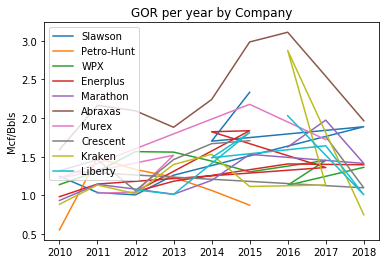

In [12]:
for i in range(len(listgoryear)):
    plt.plot(listgoryear[i]['year'],listgoryear[i]['avg'])
plt.title('GOR per year by Company')
plt.ylabel('Mcf/Bbls')
ax=plt.subplot(111)
ax.legend(['Slawson','Petro-Hunt','WPX','Enerplus','Marathon','Abraxas','Murex','Crescent','Kraken','Liberty'])
plt.show()

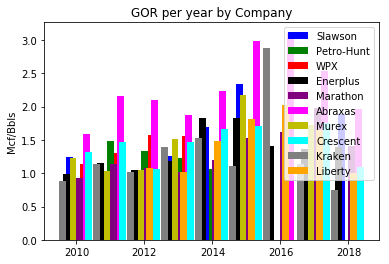

In [13]:
ax=plt.subplot(111)
ax.bar(listgoryear[0]['year']-0.2, listgoryear[0]['avg'], width=0.2, color='blue', align='center')
ax.bar(listgoryear[1]['year'], listgoryear[1]['avg'], width=0.2, color='g', align='center')
ax.bar(listgoryear[2]['year']+0.2, listgoryear[2]['avg'], width=0.2, color='r', align='center')
ax.bar(listgoryear[3]['year']-0.3, listgoryear[3]['avg'], width=0.2, color='black', align='center')
ax.bar(listgoryear[4]['year']+.1, listgoryear[4]['avg'], width=0.2, color='purple', align='center')
ax.bar(listgoryear[5]['year']+0.3, listgoryear[5]['avg'], width=0.2, color='magenta', align='center')
ax.bar(listgoryear[6]['year']-0.1, listgoryear[6]['avg'], width=0.2, color='y', align='center')
ax.bar(listgoryear[7]['year']+0.35, listgoryear[7]['avg'], width=0.2, color='cyan', align='center')
ax.bar(listgoryear[8]['year']-0.4, listgoryear[8]['avg'], width=0.2, color='gray', align='center')
ax.bar(listgoryear[9]['year']+.15, listgoryear[9]['avg'], width=0.2, color='orange', align='center')
ax.legend(['Slawson','Petro-Hunt','WPX','Enerplus','Marathon','Abraxas','Murex','Crescent','Kraken','Liberty'])
plt.title('GOR per year by Company')
plt.ylabel('Mcf/Bbls')
plt.show()

### Calculate EUR

First, I need to sort each well by month and model the data such that production begins at max production.

In [14]:
for i in range(len(wells)):
    wells[i] = wells[i].sort_values(by=['index'])
indexes = []
volumes = []
firstmonth = []
for i in range(len(wells)):
    indexes.append(wells[i]['index'])
    volumes.append(wells[i]['volume_oil_formation_bbls'])
    stmonth = [w for w, item in enumerate(volumes[i]) if item == max(volumes[i])]
    firstmonth.append(stmonth[0])
                   
# index = wells[0]['index']
# vol = wells[0]['volume_oil_formation_bbls']
# month1 = [i for i, item in enumerate(vol) if item == max(vol)]
rates = []
months = []
for i in range(len(firstmonth)):
    rates.append(np.array(volumes[i])[firstmonth[i]:])
    months.append(np.array(indexes[i])[firstmonth[i]:])

# rate = np.array(vol)[month1[0]:]
# len(months) == len(rate)
print(rates[0][0:10]) #bbls/month
print(months[0][0:10])

[4923 2960 3500 3823 3327 2982 3289 2912 2807 2510]
[65 66 67 68 69 70 71 72 73 74]


I will also need to reset the index so that peak production is 'month 1'.

In [15]:
for i in range(len(months)):
    months[i][0] = 1
    
    for k in range(1,len(months[i])):
        months[i][k] = months[i][k-1]+1
months[0][0:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

Below I've plotted a few arbitrary samples from the data set for visualization purposes.

Text(0.5, 0, 'Months')

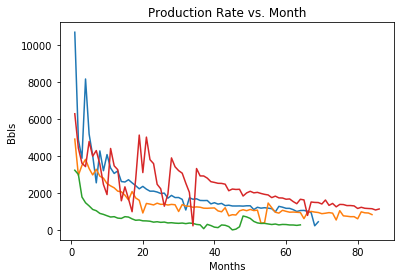

In [16]:
plt.plot(months[99],rates[99]);plt.plot(months[0],rates[0])
plt.plot(months[1],rates[1]);plt.plot(months[18],rates[18])
plt.title('Production Rate vs. Month')
plt.ylabel('Bbls')
plt.xlabel('Months')

#### Modeling decline curves with Hyperbolic Decline

The basic assumption in this procedure is that whatever causes controlled the trend of a curve in the past will continue to govern its trend in the future in a uniform manner. To model my data, I will use the Arps Equation of Hyperbolic Decline:

$$N_{p} = \left[\frac{q_i^b}{(b-1)d_i}\right]*\left[q^{(1-b)}-q_i^{(1-b)}\right]$$

where flowrate is, $$q = \frac{q_i}{(1+bd_it)^{\frac{1}{b}}}$$

Three constants:

-The initial production rate

-The initial decline rate

-The hyperbolic exponent, b

I will solve for these 3 constants with scipy's curve_fit function. I have placed some reasonble boundaries on what I think the constants could be according to their physical meanings.

In [17]:
#hyprbolic decline
q = lambda t,qi, b, di,: qi/(1+b*di*t)**(1/b)
arr= []
for i in range(len(months)):
    arre, trash = curve_fit(q,months[i],rates[i], bounds=(0, [50000, 1, 200]))
    arr.append(arre)
arr[0:4]

[array([4.44904327e+03, 1.00000000e+00, 7.58385318e-02]),
 array([4.78743980e+03, 1.00000000e+00, 4.55029364e-01]),
 array([3.81373882e+03, 1.00000000e+00, 5.11901154e-02]),
 array([5.00000000e+04, 6.65067497e-01, 8.01728842e-01])]

The values of the arrays are initial flow rate, hyperbolic exponent b, and the initial decline rate.

##### Visualisation
It appears my curve fits the dataset reasonably.

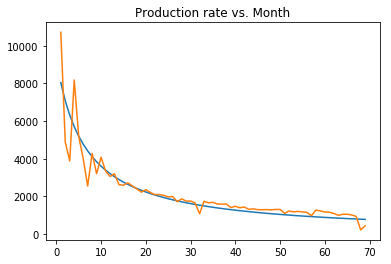

In [18]:
plt.plot(months[99],q(months[99],arr[99][0],arr[99][1],arr[99][2]))
plt.plot(months[99],rates[99])
plt.title('Production rate vs. Month')
plt.show()

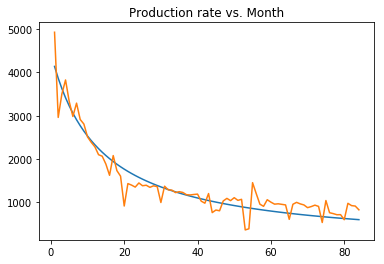

In [19]:
plt.plot(months[0],q(months[0],arr[0][0],arr[0][1],arr[0][2]))
plt.plot(months[0],rates[0])
plt.title('Production rate vs. Month')
plt.show()

Because of the nature of the Arps hyperbolic decline curve, I cannot extrapolate my model until it reaches the x axis because that would result in an infinite EUR. Instead, I will run with the assumption that each well will produce for 20 years. Although this is not a rigorous assumption, I believe that the error will have little effect on ranking EURs by well.

In [20]:
sp = np.linspace(1,240,240) #240 months = 20 years
qq = []
EUR=np.zeros(len(arr))
for i in range(len(arr)):
    EUR[i] = np.trapz(q(sp,arr[i][0],arr[i][1],arr[i][2]),dx=1)
    #calculate area of curve with trapezoidal appproximation
EUR[0:3] #bbls

array([169088.4746642 ,  45613.53936438, 189006.96442639])

##### Calculating productivity per well
To calculate productivity, I have decided to normalize EUR by the lateral length of the reservoir. This way, we can rank companies by their ability to produce hydrocarbons and not by how much land they can buy.

In [21]:
latlen = dfwell['lateral_length']
Well_productivity = np.zeros(len(arr))
for i in range(len(arr)):
    Well_productivity[i] = EUR[i]/dfwell['lateral_length'][i]
Well_productivity[0:4]

array([32.93574164,  8.93762748, 30.64598454, 23.1086186 ])

##### Calculating EUR per well that started producing in 2015
The problem statement specified to calculate only for wells that began production in the year 2015.

In [22]:
dfEUR = pd.DataFrame() #Creating a DataFrame with EUR and productivity
dfEUR['EUR'] = EUR
dfEUR['Well'] = np.arange(0,len(x))
dfEUR['year']  = production_date
dfEUR['operator'] = dfwell['operator_name']
dfEUR['productivity'] = Well_productivity
dfEUR.head()

,EUR,Well,year,operator,productivity
0,169088.474664,0,2010.0,SLAWSON EXPLORATION COMPANY INC,32.935742
1,45613.539364,1,2010.0,PETRO-HUNT DAKOTA LLC,8.937627
2,189006.964426,2,2010.0,SLAWSON EXPLORATION COMPANY INC,30.645985
3,135162.310219,3,2010.0,WPX ENERGY WILLISTON LLC,23.108619
4,332502.297053,4,2010.0,WPX ENERGY WILLISTON LLC,76.032850


In [23]:
EUR2015wells = [] #creating DataFrame of Wells from 2015 only
EUR2015wells.append(dfEUR.groupby(['year']).get_group(2015))
EUR2015wells[0]
dfEURwells = pd.DataFrame(data=EUR2015wells[0])
dfEURwells.head()

,EUR,Well,year,operator,productivity
66,496438.854928,66,2015.0,ENERPLUS RESOURCES USA CORPORATION,49.326911
67,517637.176912,67,2015.0,ENERPLUS RESOURCES USA CORPORATION,52.298628
68,525521.755146,68,2015.0,ENERPLUS RESOURCES USA CORPORATION,50.281320
69,462559.692794,69,2015.0,ENERPLUS RESOURCES USA CORPORATION,46.640379
133,594282.509101,133,2015.0,ENERPLUS RESOURCES USA CORPORATION,61.239848


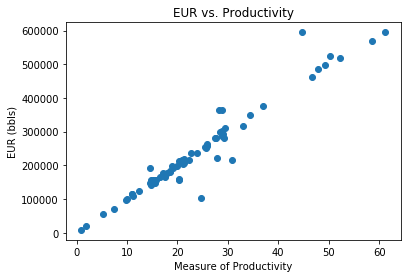

In [24]:
plt.scatter(dfEURwells['productivity'],dfEURwells['EUR'])
plt.title('EUR vs. Productivity')
plt.xlabel('Measure of Productivity')
plt.ylabel('EUR (bbls)')
plt.show()

It is clear that companies with higher estimated EURS were given higher productivity measures. I believe this is because of the wide variability in EUR and the small variability in lateral length of the producing reservoir. My reccomendation is to look into this trend more deeply before making business decisions from this result.

In [25]:
opsort=[]
for i in range(len(y)):
    opsort.append(dfEURwells.groupby(['operator']).get_group(y[i]))
finallist = []
dftoav = pd.DataFrame()
dd = np.zeros(len(opsort))
ee = np.zeros(len(opsort))
for i in range(len(opsort)):
    dd[i] = np.average(opsort[i]['productivity'])
    ee[i] = np.sum(opsort[i]['EUR'])
dftoav['Total EUR'] = ee
dftoav['Productivity Average'] = dd
dftoav['Company'] = y

## Final Results of EUR/Productivity per Company
The results indicate that Enerplus Resources, Abraxas, and Marathon will drill the best wells going forward. It is relevent to note that Abraxas has had the highest GOR in this group of companies since 2010.

In [26]:
dftoav.sort_values(by=['Total EUR'])

,Total EUR,Productivity Average,Company
6,3.572680e+05,18.212293,MUREX PETROLEUM CORPORATION
7,3.859426e+05,13.007591,CRESCENT POINT ENERGY US CORP
8,7.898269e+05,15.755028,KRAKEN OPERATING LLC
0,8.590950e+05,24.772991,SLAWSON EXPLORATION COMPANY INC
2,9.094196e+05,28.841832,WPX ENERGY WILLISTON LLC
4,1.514696e+06,29.063098,MARATHON OIL COMPANY
5,2.083194e+06,29.875435,ABRAXAS PETROLEUM CORP
9,2.442383e+06,14.193809,LIBERTY RESOURCES MANAGEMENT COMPANY LLC
1,2.816101e+06,20.128634,PETRO-HUNT DAKOTA LLC
3,3.999390e+06,50.073945,ENERPLUS RESOURCES USA CORPORATION


In [28]:
dftoav.sort_values(by=['Productivity Average'])

,Total EUR,Productivity Average,Company
7,3.859426e+05,13.007591,CRESCENT POINT ENERGY US CORP
9,2.442383e+06,14.193809,LIBERTY RESOURCES MANAGEMENT COMPANY LLC
8,7.898269e+05,15.755028,KRAKEN OPERATING LLC
6,3.572680e+05,18.212293,MUREX PETROLEUM CORPORATION
1,2.816101e+06,20.128634,PETRO-HUNT DAKOTA LLC
0,8.590950e+05,24.772991,SLAWSON EXPLORATION COMPANY INC
2,9.094196e+05,28.841832,WPX ENERGY WILLISTON LLC
4,1.514696e+06,29.063098,MARATHON OIL COMPANY
5,2.083194e+06,29.875435,ABRAXAS PETROLEUM CORP
3,3.999390e+06,50.073945,ENERPLUS RESOURCES USA CORPORATION
